<p style="font-size:78px">Final Project IRWA (2024-2025)</p>

<p style="font-size:48px">Part 1: Text Processing and Exploratory Data Analysis</p>

In [35]:
# Standard library imports
import os
import sys
from collections import Counter
from itertools import chain
from statistics import mean

# Third-party imports
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

# Local application imports
current_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
project_root = os.path.join(current_dir, '..')
if project_root not in sys.path:
    sys.path.append(project_root)
import irwa.loading as ild 
import irwa.preprocessing as ipp

# The following lines allow for autoreload of modules. They allow changes in modules without the need to reload the kernel.
%load_ext autoreload
%autoreload 2

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('vader_lexicon')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\yo\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\yo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\yo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     C:\Users\yo\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker_

True

# 1) Pre-processing the documents

In [2]:
# Loading the tweets
file_path = '../data/farmers-protest-tweets.json'
tweets = ild.load_tweets_from_json(file_path)
print(f"Loaded {len(tweets)} tweets")

Loaded 117407 tweets


In [3]:
# Preprocessing the tweets
tweet_document_ids_map_df = "../data/tweet_document_ids_map.csv"
token_tweets = ipp.create_tokenized_dictionary(tweets, tweet_document_ids_map_df)

In [26]:
# Look at first 5 documents to make sure preprocessing worked
for doc_id, tokens in list(token_tweets.items())[:5]:
    print(f"Document ID: {doc_id}, Tokens: {tokens}")

Document ID: doc_0, Tokens: ['world', 'progress', 'indian', 'polic', 'govt', 'still', 'tri', 'take', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame', '#modidontsellfarm', '#farmersprotest', '#freenodeepkaur', 'https://t.co/es3kn0iqaf']
Document ID: doc_1, Tokens: ['#farmersprotest', '#modiignoringfarmersdeath', '#modidontsellfarm', 'kisanektamorcha', 'farmer', 'constantli', 'distroy', 'crop', 'throughout', 'india', 'realli', 'heart', 'breakingw', 'care', 'crop', 'like', 'children', 'govt', 'agricultur', 'minist', 'laugh', 'us🚜🌾w', 'win💪', 'https://t.co/klspngg9xe']
Document ID: doc_2, Tokens: ['reallyswara', 'rohinisgh', 'watch', 'full', 'video', '#farmersprotest', '#nofarmersnofood', 'https://t.co/wbpndjdb0n', 'https://t.co/fustokocxk']
Document ID: doc_3, Tokens: ['mandeeppunia1', 'watch', 'full', 'video', '#farmersprotest', '#nofarmersnofood', 'https://t.co/wbpndjdb0n', 'https://t.co/71imqec6ak']
Document ID: doc_4, Tokens: ['mandeeppunia1', 'watc

# 2) Exploratory Data Analysis

## Word Count

In [36]:
def word_count(tweets, top_words, count_type='all'):

    all_words = list(chain.from_iterable(tweets.values()))

    if count_type == "hashtags":
        words_to_count = [word for word in all_words if word.startswith('#')]  
    elif count_type == "no_hashtags":
        words_to_count = [word for word in all_words if not word.startswith('#')] 
    else:
        words_to_count = all_words  

    word_counts= Counter(words_to_count)

    most_common_words = word_counts.most_common(top_words)

    return word_counts, most_common_words



def plot_word_counts(most_common_words):
    
    most_common_words.sort(key=lambda x: x[1], reverse=True)
    words, counts = zip(*most_common_words) 

    norm_counts = np.array(counts) / max(counts)

    plt.figure(figsize=(10, 6 + len(most_common_words) * 0.25))  
    bars = plt.barh(words, counts, color=plt.cm.Blues(norm_counts))

    for bar, count in zip(bars, counts):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(count), 
                 ha='left', va='center', fontsize=10)

    plt.title('Most Common Words in Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()



### Inlcuding all words

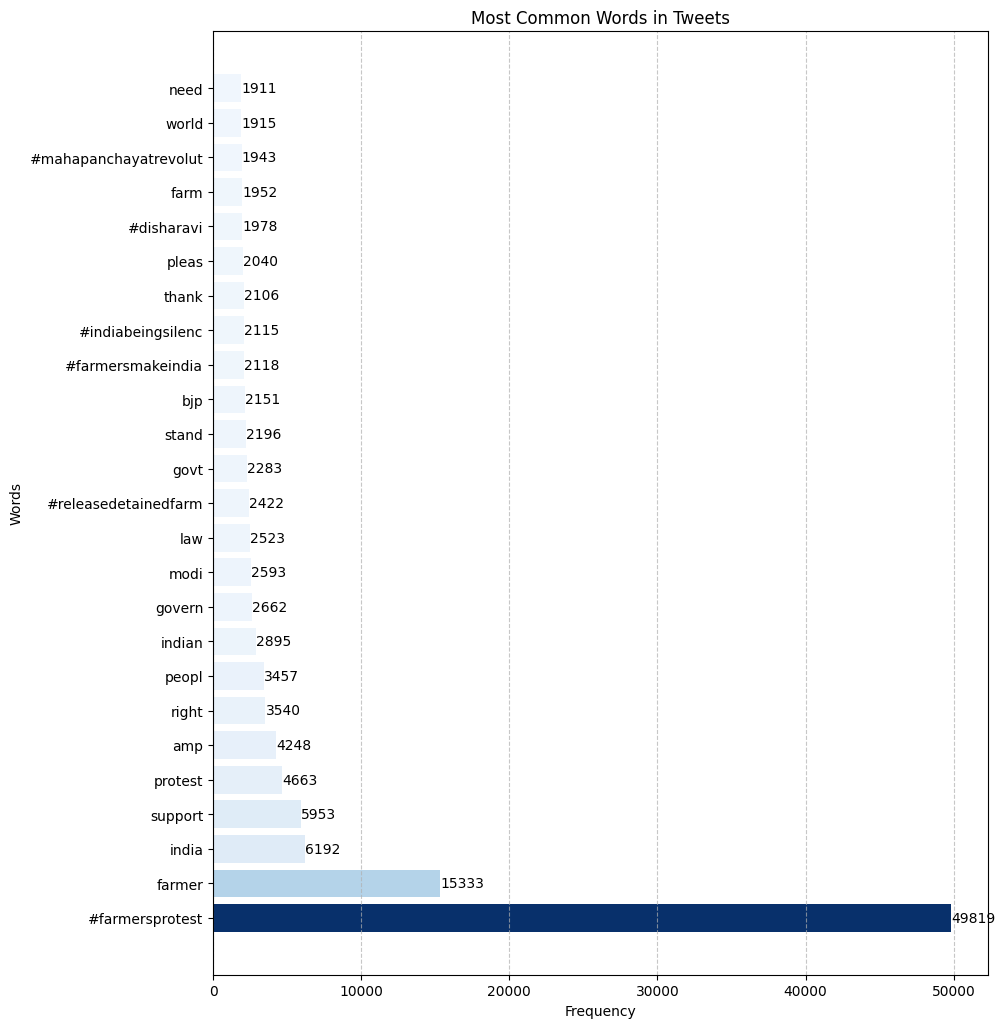

In [37]:
word_counts_all, most_common_words_all = word_count(token_tweets, 25, 'all')
plot_word_counts(most_common_words_all)

### Only Hashtags

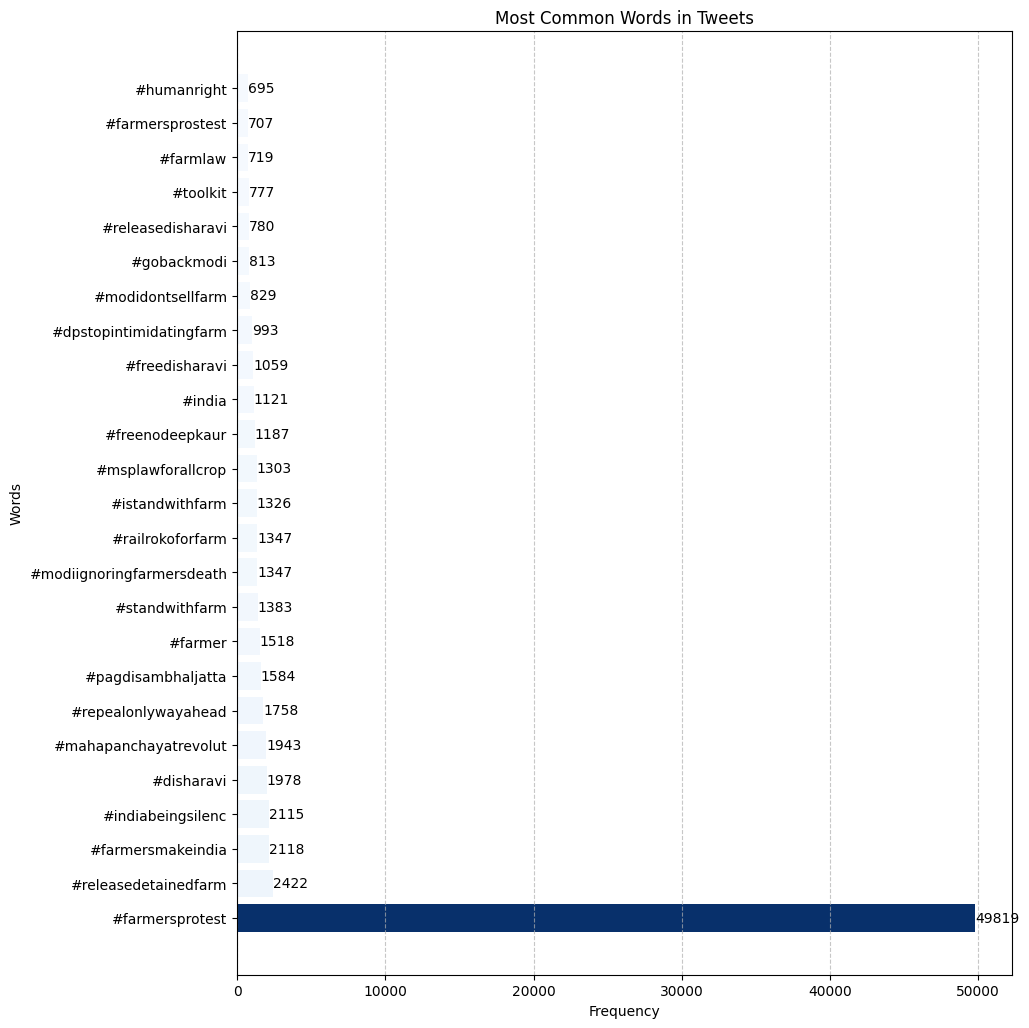

In [29]:
word_counts_ht, most_common_words_ht = word_count(token_tweets, 25, 'hashtags')
plot_word_counts(most_common_words_ht)

### No Hashtags

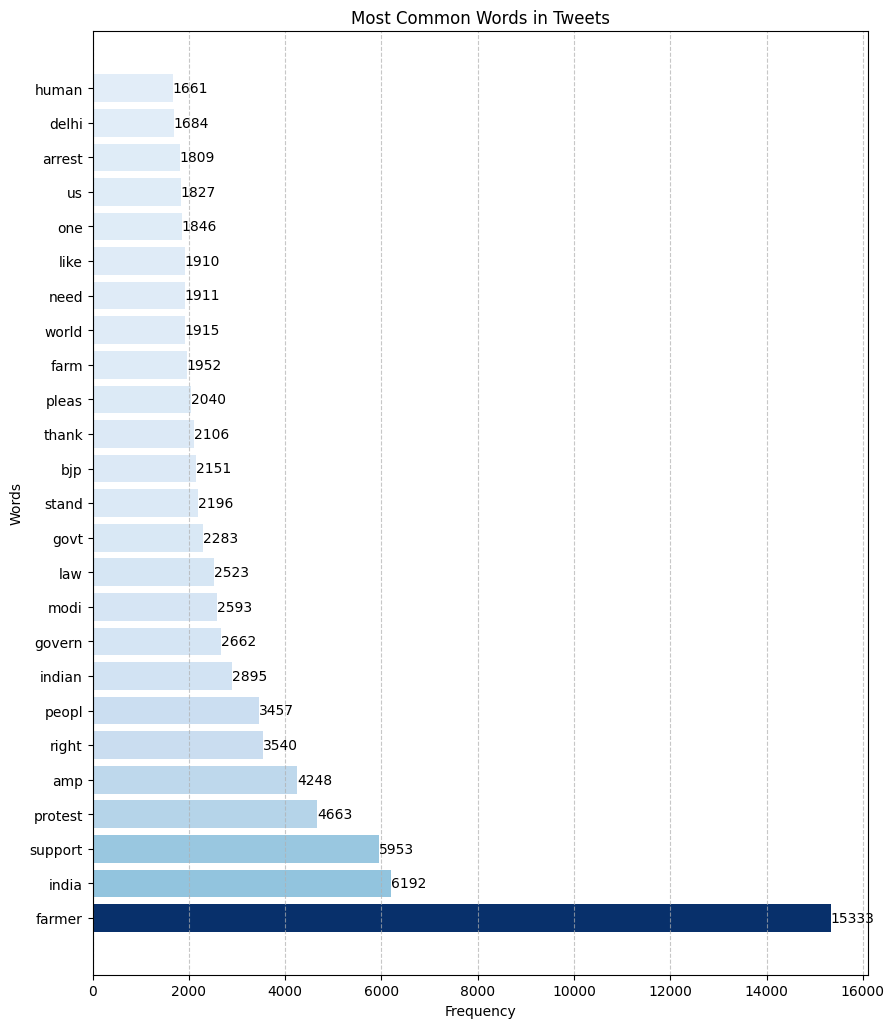

In [30]:
word_counts_noht, most_common_words_noht = word_count(token_tweets, 25, 'no_hashtags')
plot_word_counts(most_common_words_noht)

## Average Sentence Length

In [31]:
def average_sentence_length(token_tweets):
    sentence_lengths = []

    for tokenized_content in token_tweets.values():
        sentence_count = 1  # Since tokenized_content corresponds to one document (one "sentence")
        word_count = len(tokenized_content)  # Number of words in the tokenized content

        avg_length = word_count / sentence_count
        sentence_lengths.append(avg_length)

    # Compute overall average sentence length
    avg_sentence_length = mean(sentence_lengths)
    return avg_sentence_length
avg_sentence_length = average_sentence_length(token_tweets)

print(f"📊 Average Sentence Length")
print(f"-----------------------------------")
print(f"The average sentence length is {avg_sentence_length:.2f} words")


📊 Average Sentence Length
-----------------------------------
The average sentence length is 14.99 words


## Most retweeted Tweets

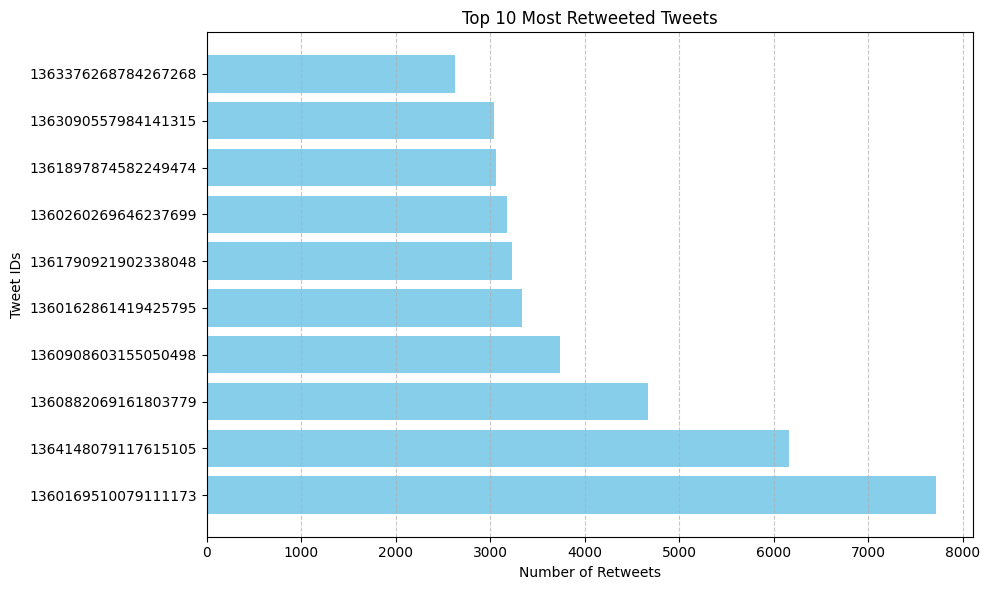

Tweet ID: 1360169510079111173. Content: मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान खरीदकर भाग गया। किसान पैसे के लिए धरना दे रहे है।
अब भी बताना पड़ेगा काला क्या है
#FarmLaws #FarmersProtest #किसान_एकता_जिंदाबाद
Tweet ID: 1364148079117615105. Content: There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8
Tweet ID: 1360882069161803779. Content: disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. 

disha’s arrest is alarming and the world needs to pay attention. #freedisharavi

https://t.co/IYGsLpNjwZ
Tweet ID: 1360908603155050498. Content: Disha Ravi broke down in court room and told judge that she had merely edited two lines in the toolk

In [33]:
def top_retweeted_tweets(tweets, n=10):
    tweets = [tweet for _, tweet in tweets.items()]
    ranked_tweets = sorted(tweets, key=lambda tweet: tweet._retweet_count, reverse=True)
    top_retweets = [(tweet._tweet_id, tweet._retweet_count, tweet._content) for tweet in ranked_tweets[:n]] 
    return top_retweets


def plot_top_retweet_tweets(tweets, n=10):
    
    # Check if the input list is empty
    if not tweets:
        print("No tweets to display.")
        return
    
    top_tweets = top_retweeted_tweets(tweets, n)
    
    # Unzip the tweet IDs and retweet counts
    tweet_ids, retweet_counts, retweet_content = zip(*top_tweets)
    tweet_ids = list(map(str, tweet_ids))  # Convert tweet IDs to string if necessary


    # Create a horizontal bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(tweet_ids, retweet_counts, color='skyblue')

    plt.title('Top 10 Most Retweeted Tweets')
    plt.xlabel('Number of Retweets')
    plt.ylabel('Tweet IDs')
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add gridlines for better readability
    plt.tight_layout()

    plt.show()

    for tweet_id, _, retweet_content in top_tweets:
        print(f"Tweet ID: {tweet_id}. Content: {retweet_content}")

plot_top_retweet_tweets(tweets)



## Word Cloud

In [33]:
def create_word_cloud(word_counts, top_words):
    
    # Get the most common words
    most_common_words = word_counts.most_common(top_words)

    # Create a WordCloud object with custom settings
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',  # Dark background for contrast
        colormap='Set2',           # Color palette for the words
        max_words=top_words,       # Maximum number of words to display
    ).generate_from_frequencies(dict(most_common_words))

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axis
    plt.title('Word Cloud of Most Common Words', fontsize=18, color='black', pad=20)
    plt.show()



### Including all words

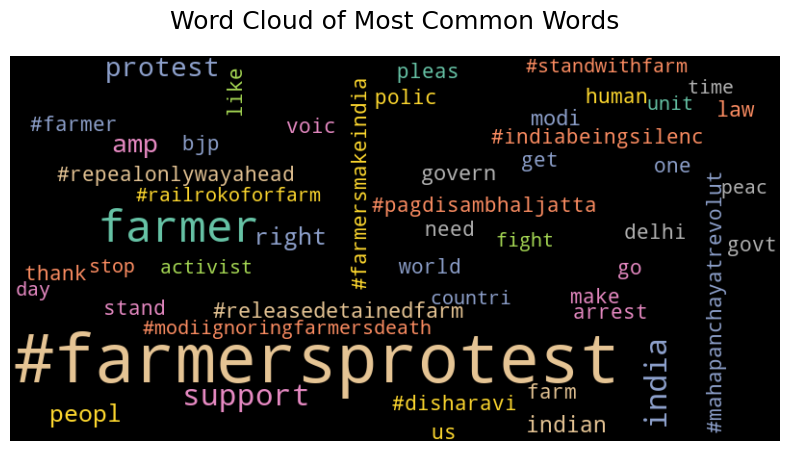

In [34]:
# Use the word counts from the earlier analysis
create_word_cloud(word_counts_all, 50)

### Only Hashtags

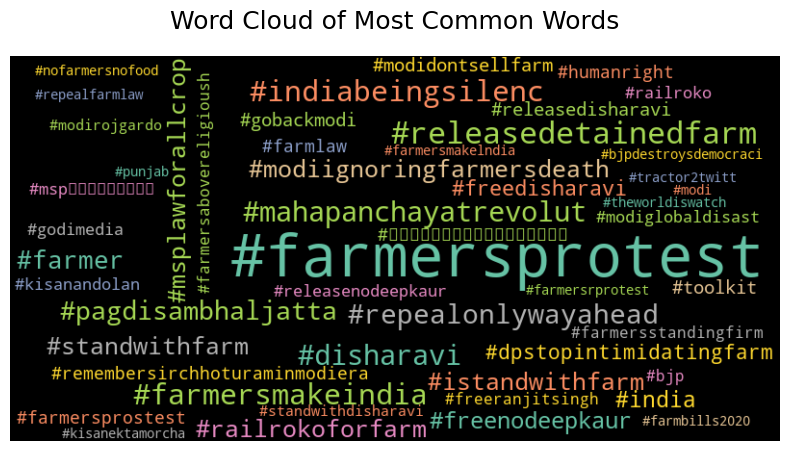

In [35]:
# Use the word counts from the earlier analysis
create_word_cloud(word_counts_ht, 50)

### No Hashtags

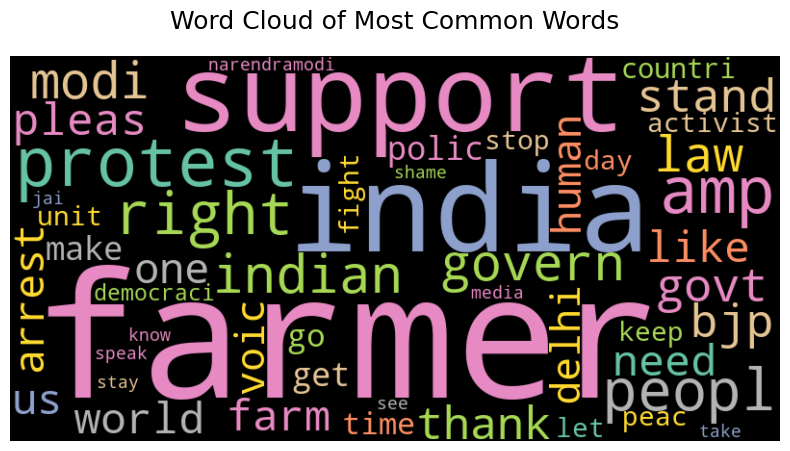

In [36]:
# Use the word counts from the earlier analysis
create_word_cloud(word_counts_noht, 50)

## Named Entities

In [8]:
def entity_recognition_nltk(token_tweets):
    entities = []
    
    for tokenized_content in token_tweets.values():
        # No need to tokenize; tokenized_content is already a list of words
        pos_tags = nltk.pos_tag(tokenized_content)  # POS tagging
        
        # Perform Named Entity Recognition (NER)
        tree = nltk.ne_chunk(pos_tags, binary=True)  # NER with binary=True (labels everything as NE or not)

        # Extract named entities
        for subtree in tree:
            if hasattr(subtree, 'label') and subtree.label() == 'NE':  # Check for named entities
                entity = " ".join([word for word, tag in subtree])  # Join words to form the entity
                entities.append(entity)
    
    return entities

named_entities = entity_recognition_nltk(token_tweets)
print("Named entities:", named_entities)


KeyboardInterrupt: 

In [39]:
def display_entities(entities):
    # Count the unique named entities
    unique_entities = set(entities)
    entity_count = len(unique_entities)
    
    # Print the count of unique named entities
    print(f"Total unique named entities found: {entity_count}\n")
    
    # Print each unique entity
    print("Unique Named Entities:")
    for entity in unique_entities:
        print(f"- {entity}")

display_entities(named_entities)

NameError: name 'named_entities' is not defined

## Sentiment Analysis

We've decided to also do a sentiment analysis study that can be really usefull to understand the data.

In [14]:
def calculate_sentiment_scores(token_tweets):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = {}

    # Iterate over the dictionary with tokenized tweets
    for tweet_id, token_list in token_tweets.items():
        # Join the token list back into a single string
        tweet_text = ' '.join(token_list)
        sentiment = analyzer.polarity_scores(tweet_text)  # Get sentiment scores
        sentiment_scores[tweet_id] = sentiment['compound']  # Use compound score

    return sentiment_scores

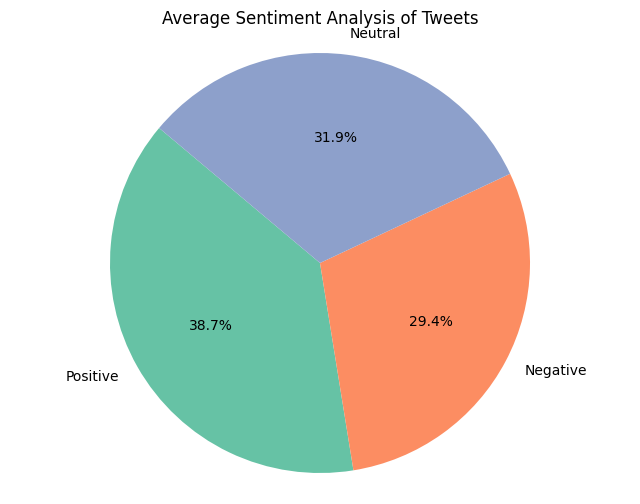

In [16]:

def plot_sentiment_pie(sentiment_scores):
    
    # Categorize each tweet's sentiment
    sentiment_categories = {'Positive': 0, 'Negative': 0, 'Neutral': 0}
    
    for score in sentiment_scores.values():
        if score > 0:
            sentiment_categories['Positive'] += 1
        elif score < 0:
            sentiment_categories['Negative'] += 1
        else:
            sentiment_categories['Neutral'] += 1

    # Prepare data for pie chart
    labels = list(sentiment_categories.keys())
    sizes = list(sentiment_categories.values())
    
    # Create a pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
    plt.title('Average Sentiment Analysis of Tweets')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

sentiment_scores = calculate_sentiment_scores(token_tweets)
plot_sentiment_pie(sentiment_scores)